# Disease Grading classification

## Disease Grading Classification Workflow

1. 📁 **Set up paths**  
    Defined all directory and file paths for images, masks, and CSVs.

2. 🗂️ **Copy images for classification**  
    Wrote a helper function to copy training and testing images into dedicated folders for classification.

3. 🏷️ **Create custom Dataset class**  
    Implemented `IDRiDClassificationDataset` to load images and labels from CSVs.

4. 🖼️ **Define image transforms**  
    Used torchvision transforms for data augmentation (train) and normalization (train/test).

5. 🗺️ **Map labels and create datasets**  
    Created `train_dataset` and `test_dataset` using the custom dataset class and transforms.

6. 📦 **Create DataLoaders**  
    Wrapped datasets in PyTorch DataLoaders for batching and shuffling.

7. 🏗️ **Build the model**  
    Defined a function to build a ResNet18 classifier with a custom output layer for 5 classes.

8. ⚖️ **Compute class weights**  
    Used `sklearn` to calculate class weights for handling class imbalance.

9. 🔁 **Training loop**  
    Implemented a training loop with early stopping, label smoothing, and class weights.

10. 💾 **Save the best model**  
     Saved the trained model weights to disk.

11. 🧪 **Evaluate on test set**  
     Evaluated the model on the test set and computed accuracy.

12. 📊 **Plot metrics**  
     Plotted training/validation loss and accuracy curves.

13. 🧮 **Confusion matrix**  
     Plotted a confusion matrix to visualize prediction performance across classes.

14. 📝 **Classification report**  
     Printed a detailed classification report (precision, recall, F1-score) for each class.

15. 📄 **Save predictions**  
     Saved true and predicted labels for the test set to a CSV file.

16. 👁️ **Visualize predictions**  
     Displayed sample test images with predicted and true labels for qualitative inspection.

17. 🗒️ **Log results**  
     Logged model performance metrics and notes to a CSV file for future reference.
----

## Paths

In [ ]:
import os

# 🔧 Paths 
BASE_DIR = 'your base path here'  # Replace with your actual base path
SEG_IMG_DIR = os.path.join(BASE_DIR, 'A. Segmentation/1. Original Images/a. Training Set')
MASK_BASE_DIR = os.path.join(BASE_DIR, 'A. Segmentation/2. All Segmentation Groundtruths/a. Training Set')
GRADE_IMG_DIR = os.path.join(BASE_DIR, 'B. Disease Grading/1. Original Images/a. Training Set')
DG_CSV = os.path.join(BASE_DIR, 'B. Disease Grading/2. Groundtruths', 'a. IDRiD_Disease Grading_Training Labels.csv')

CLASSIFICATION_DIR = os.path.join(BASE_DIR, 'IDRiD_Classification')


In [2]:
import pandas as pd
import shutil

# 🚩 Source directories
SOURCE_TRAIN_DIR = GRADE_IMG_DIR  # Already: a. Training Set
SOURCE_TEST_DIR = os.path.join(BASE_DIR, 'B. Disease Grading/1. Original Images/b. Testing Set')

# 📄 Label CSVs expected inside IDRiD_Classification
TRAIN_CSV = os.path.join(BASE_DIR, 'B. Disease Grading/2. Groundtruths', 'a. IDRiD_Disease Grading_Training Labels.csv')
TEST_CSV = os.path.join(BASE_DIR, 'B. Disease Grading/2. Groundtruths', 'b. IDRiD_Disease Grading_Testing Labels.csv')

# 🚩 Destination directories
TRAIN_DEST = os.path.join(CLASSIFICATION_DIR, 'train')
TEST_DEST = os.path.join(CLASSIFICATION_DIR, 'test')
os.makedirs(TRAIN_DEST, exist_ok=True)
os.makedirs(TEST_DEST, exist_ok=True)

# 🧱 Helper function
def copy_images(csv_path, source_dir, target_dir):
    df = pd.read_csv(csv_path)
    df['Image name'] = df['Image name'].str.replace('.jpg', '', regex=False)

    for img_id in df['Image name']:
        src = os.path.join(source_dir, img_id + '.jpg')
        dst = os.path.join(target_dir, img_id + '.jpg')
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            print(f"⚠️ Missing image: {src}")

# 🔁 Run for both splits
print("📁 Copying training images...")
# copy_images(TRAIN_CSV, SOURCE_TRAIN_DIR, TRAIN_DEST)

print("📁 Copying testing images...")
# copy_images(TEST_CSV, SOURCE_TEST_DIR, TEST_DEST)

print("\n✅ All images copied successfully into IDRiD_Classification/train and /test!")
print("-------Skipping-------")


📁 Copying training images...
📁 Copying testing images...

✅ All images copied successfully into IDRiD_Classification/train and /test!
-------Skipping-------


## Classification class

In [3]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class IDRiDClassificationDataset(Dataset):
    def __init__(self, image_dir, label_csv, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # 🧾 Load labels
        df = pd.read_csv(label_csv)
        df['Image name'] = df['Image name'].str.replace('.jpg', '', regex=False)
        self.image_ids = df['Image name'].tolist()
        self.labels = df['Retinopathy grade'].tolist()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        label = self.labels[idx]

        img_path = os.path.join(self.image_dir, image_id + '.jpg')
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


## Transform the images

In [4]:
from torchvision import transforms

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])



train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## Mapping the labels

In [5]:
train_dataset = IDRiDClassificationDataset(
    image_dir=os.path.join(CLASSIFICATION_DIR, 'train'),
    label_csv=os.path.join(BASE_DIR, 'B. Disease Grading/2. Groundtruths', 'a. IDRiD_Disease Grading_Training Labels.csv'),
    transform=train_transform
)

test_dataset = IDRiDClassificationDataset(
    image_dir=os.path.join(CLASSIFICATION_DIR, 'test'),
    label_csv=os.path.join(BASE_DIR, 'B. Disease Grading/2. Groundtruths', 'b. IDRiD_Disease Grading_Testing Labels.csv'),
    transform=test_transform
)


## Create Data Loaders

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

img, label = train_dataset[0]
print("🖼️ Image shape:", img.shape)
print("🏷️ Label:", label)


🖼️ Image shape: torch.Size([3, 224, 224])
🏷️ Label: 3


## Building the model

### ResNet34

In [7]:
# import torchvision.models as models
# import torch.nn as nn

# def build_resnet34_classifier(num_classes=5):
#     model = models.resnet34(pretrained=True)
#     model.fc = nn.Linear(model.fc.in_features, num_classes)
#     return model

# # 🔁 Rebuild fresh model
# model = build_resnet34_classifier(num_classes=5)


### ResNet18

In [8]:
import torchvision.models as models
import torch.nn as nn

def build_resnet18_classifier(num_classes=5):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# 🔁 Try ResNet18
model = build_resnet18_classifier(num_classes=5)
print(model.fc)

Linear(in_features=512, out_features=5, bias=True)


/Users/niharika/Downloads/Akeso assignment/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/niharika/Downloads/Akeso assignment/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model = build_resnet18_classifier(num_classes=5)
print(model.fc)  # Should show: Linear(in_features=512, out_features=5)

Linear(in_features=512, out_features=5, bias=True)


## Class weights

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

y_train = train_dataset.labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_tensor = torch.tensor(class_weights, dtype=torch.float)


## Training Loop

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-4, patience=3):
    device = torch.device("cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    # 📊 Track metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # ⏹️ Early stopping counter
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # 🚂 Train
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects / len(train_loader.dataset)

        # 🧪 Validate
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Val", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects / len(val_loader.dataset)

        # 📊 Log
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f"✅ Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.4f}")
        print(f"🧪 Val   Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.4f}")

        # 🔐 Best model check
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print("💾 Best model updated!")
        else:
            epochs_no_improve += 1
            print(f"⏹️ No improvement for {epochs_no_improve} epoch(s).")

        # ⏹️ Early stopping
        if epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping triggered after {epoch+1} epochs.")
            break

    model.load_state_dict(best_model_wts)
    return model, history


In [12]:
model, history = train_model(
    model,
    train_loader,
    test_loader,
    num_epochs=12,
    lr=1e-4,
    patience=4
)


🔁 Epoch 1/12
------------------------------


✅ Train Loss: 1.6129 | Acc: 0.3293
🧪 Val   Loss: 1.7447 | Acc: 0.4272
💾 Best model updated!

🔁 Epoch 2/12
------------------------------


✅ Train Loss: 1.3214 | Acc: 0.5230
🧪 Val   Loss: 1.5639 | Acc: 0.4757
💾 Best model updated!

🔁 Epoch 3/12
------------------------------


✅ Train Loss: 1.1827 | Acc: 0.6368
🧪 Val   Loss: 1.5609 | Acc: 0.4563
⏹️ No improvement for 1 epoch(s).

🔁 Epoch 4/12
------------------------------


✅ Train Loss: 1.1029 | Acc: 0.6586
🧪 Val   Loss: 1.6192 | Acc: 0.5049
💾 Best model updated!

🔁 Epoch 5/12
------------------------------


✅ Train Loss: 1.0622 | Acc: 0.7506
🧪 Val   Loss: 1.5731 | Acc: 0.4369
⏹️ No improvement for 1 epoch(s).

🔁 Epoch 6/12
------------------------------


✅ Train Loss: 0.9655 | Acc: 0.7676
🧪 Val   Loss: 1.5108 | Acc: 0.5437
💾 Best model updated!

🔁 Epoch 7/12
------------------------------


✅ Train Loss: 0.9585 | Acc: 0.8063
🧪 Val   Loss: 1.6317 | Acc: 0.5728
💾 Best model updated!

🔁 Epoch 8/12
------------------------------


✅ Train Loss: 0.8830 | Acc: 0.8305
🧪 Val   Loss: 1.6277 | Acc: 0.5049
⏹️ No improvement for 1 epoch(s).

🔁 Epoch 9/12
------------------------------


✅ Train Loss: 0.9175 | Acc: 0.8281
🧪 Val   Loss: 1.6159 | Acc: 0.4660
⏹️ No improvement for 2 epoch(s).

🔁 Epoch 10/12
------------------------------


✅ Train Loss: 0.8616 | Acc: 0.8692
🧪 Val   Loss: 1.7397 | Acc: 0.5146
⏹️ No improvement for 3 epoch(s).

🔁 Epoch 11/12
------------------------------


✅ Train Loss: 0.7957 | Acc: 0.8935
🧪 Val   Loss: 1.6740 | Acc: 0.3495
⏹️ No improvement for 4 epoch(s).

🛑 Early stopping triggered after 11 epochs.


In [13]:
torch.save(model.state_dict(), 'resnet18_best_classification.pth')

## Log model report after testing

In [14]:
import csv
import os
from sklearn.metrics import classification_report, accuracy_score

def log_model_results(
    model_name,
    model,
    history,
    test_loader,
    label_names=['0', '1', '2', '3', '4'],
    csv_path="model_results_log.csv",
    notes=""
):
    model.eval()
    device = torch.device("cpu")
    model.to(device)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, output_dict=True, target_names=label_names)
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1 = report['macro avg']['f1-score']

    # Log to CSV
    file_exists = os.path.isfile(csv_path)
    with open(csv_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow([
                "Model", "Test Acc", 
                "Train Acc (last)", "Val Acc (last)",
                "Train Loss (last)", "Val Loss (last)",
                "Macro Precision", "Macro Recall", "Macro F1",
                "Notes"
            ])

        writer.writerow([
            model_name,
            f"{acc:.4f}",
            f"{history['train_acc'][-1]:.4f}",
            f"{history['val_acc'][-1]:.4f}",
            f"{history['train_loss'][-1]:.4f}",
            f"{history['val_loss'][-1]:.4f}",
            f"{macro_precision:.4f}",
            f"{macro_recall:.4f}",
            f"{macro_f1:.4f}",
            notes
        ])

    print(f"✅ Logged results for {model_name} to {csv_path}")


## Testing the model

In [15]:
from sklearn.metrics import accuracy_score

def evaluate_on_test(model, test_loader):
    device = torch.device("cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # 🔮 Get predicted class
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 🎯 Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Final Test Accuracy: {acc*100:.4f}")

    return all_labels, all_preds


In [16]:
labels, preds = evaluate_on_test(model, test_loader)


log_model_results(
    model_name="ResNet18",  # or "ResNet18"
    model=model,
    history=history,
    test_loader=test_loader,
    notes="Aug, class weights, label smoothing"
)


✅ Final Test Accuracy: 57.2816
✅ Logged results for ResNet18 to model_results_log.csv


## Plot metrics

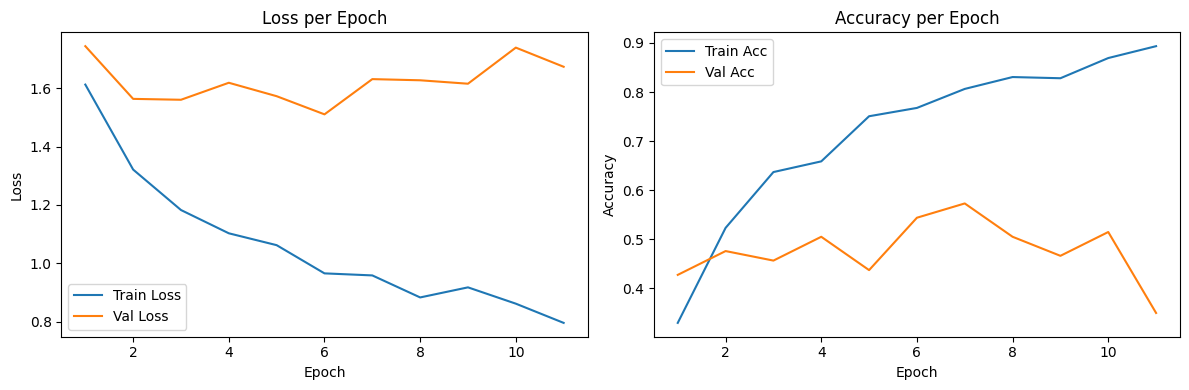

In [17]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # 🔻 Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # 🔺 Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ✅ Run this AFTER training:
plot_metrics(history)


## Confusion matrix

📁 Confusion matrix saved to: ./resnet_confusion_matrix.png


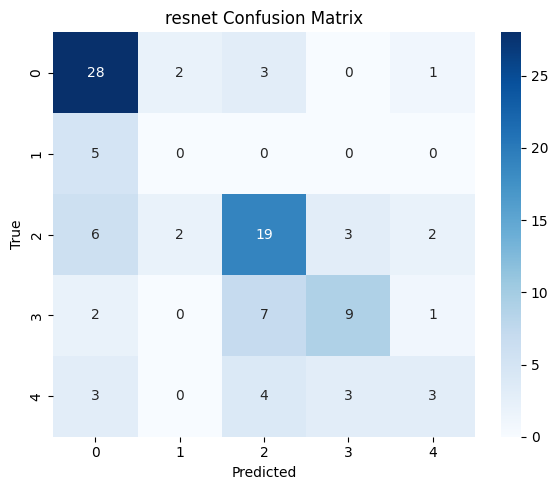

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_confusion_matrix(labels, preds, class_names, model_name="resnet", save_dir="."):
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} Confusion Matrix")
    plt.tight_layout()

    # ✅ Save to file
    filename = f"{model_name.lower()}_confusion_matrix.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f"📁 Confusion matrix saved to: {save_path}")

    plt.show()


# Example usage
class_names = ['0', '1', '2', '3', '4']
plot_confusion_matrix(labels, preds, class_names)

## Classification Report

In [19]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds, target_names=class_names))

              precision    recall  f1-score   support

           0       0.64      0.82      0.72        34
           1       0.00      0.00      0.00         5
           2       0.58      0.59      0.58        32
           3       0.60      0.47      0.53        19
           4       0.43      0.23      0.30        13

    accuracy                           0.57       103
   macro avg       0.45      0.42      0.43       103
weighted avg       0.55      0.57      0.55       103



## Save predictions to csv

In [20]:
import pandas as pd

df = pd.DataFrame({
    'True Label': labels,
    'Predicted Label': preds
})

df.to_csv("test_predictions.csv", index=False)
print("📁 Saved to test_predictions_18.csv")


📁 Saved to test_predictions_18.csv


## Visualize Image Predictions

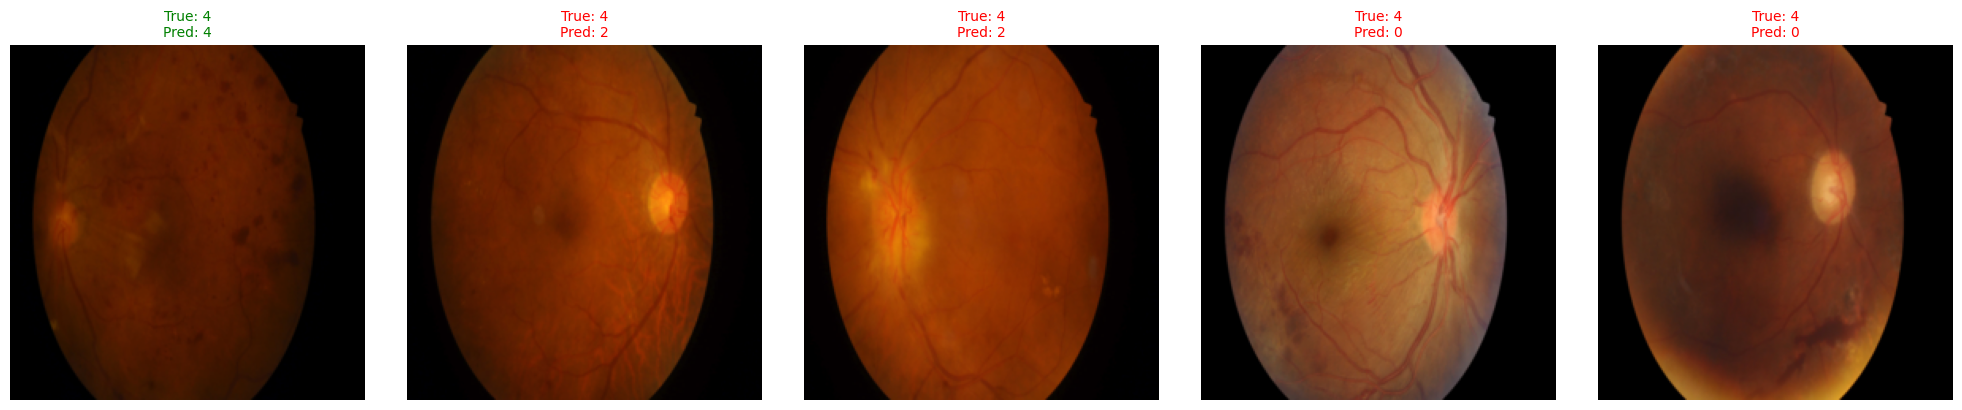

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions_row(model, dataset, num_samples=5):
    model.eval()
    device = torch.device("cpu")
    model.to(device)

    fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(num_samples):
        img, label = dataset[i]

        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))
            _, pred = torch.max(output, 1)

        # 🧼 Unnormalize
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np * std) + mean  # Unnormalize
        img_np = np.clip(img_np, 0, 1)

        ax = axes[i]
        ax.imshow(img_np)
        ax.axis('off')
        is_correct = pred.item() == label
        color = 'green' if is_correct else 'red'
        ax.set_title(f"True: {label}\nPred: {pred.item()}", fontsize=10, color=color)

    plt.tight_layout()
    plt.show()

show_predictions_row(model, test_dataset, num_samples=5)


---

# Comparing the models

## Classification results

In [22]:
import pandas as pd

# Load the log file
df = pd.read_csv("model_results_log.csv")

# Check contents
display(df)

,Model,Test Acc,Train Acc (last),Val Acc (last),Train Loss (last),Val Loss (last),Macro Precision,Macro Recall,Macro F1,Notes
0,ResNet34,0.5243,0.7288,0.3107,1.0344,1.8018,0.4738,0.3725,0.3802,"Aug, class weights, label smoothing"
1,ResNet18,0.5728,0.8935,0.3495,0.7957,1.6740,0.4481,0.4243,0.4264,"Aug, class weights, label smoothing"


/var/folders/mm/6sxz47951nqc517cg25z2py80000gn/T/ipykernel_9975/1001257338.py:49: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/Users/niharika/Downloads/Akeso assignment/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


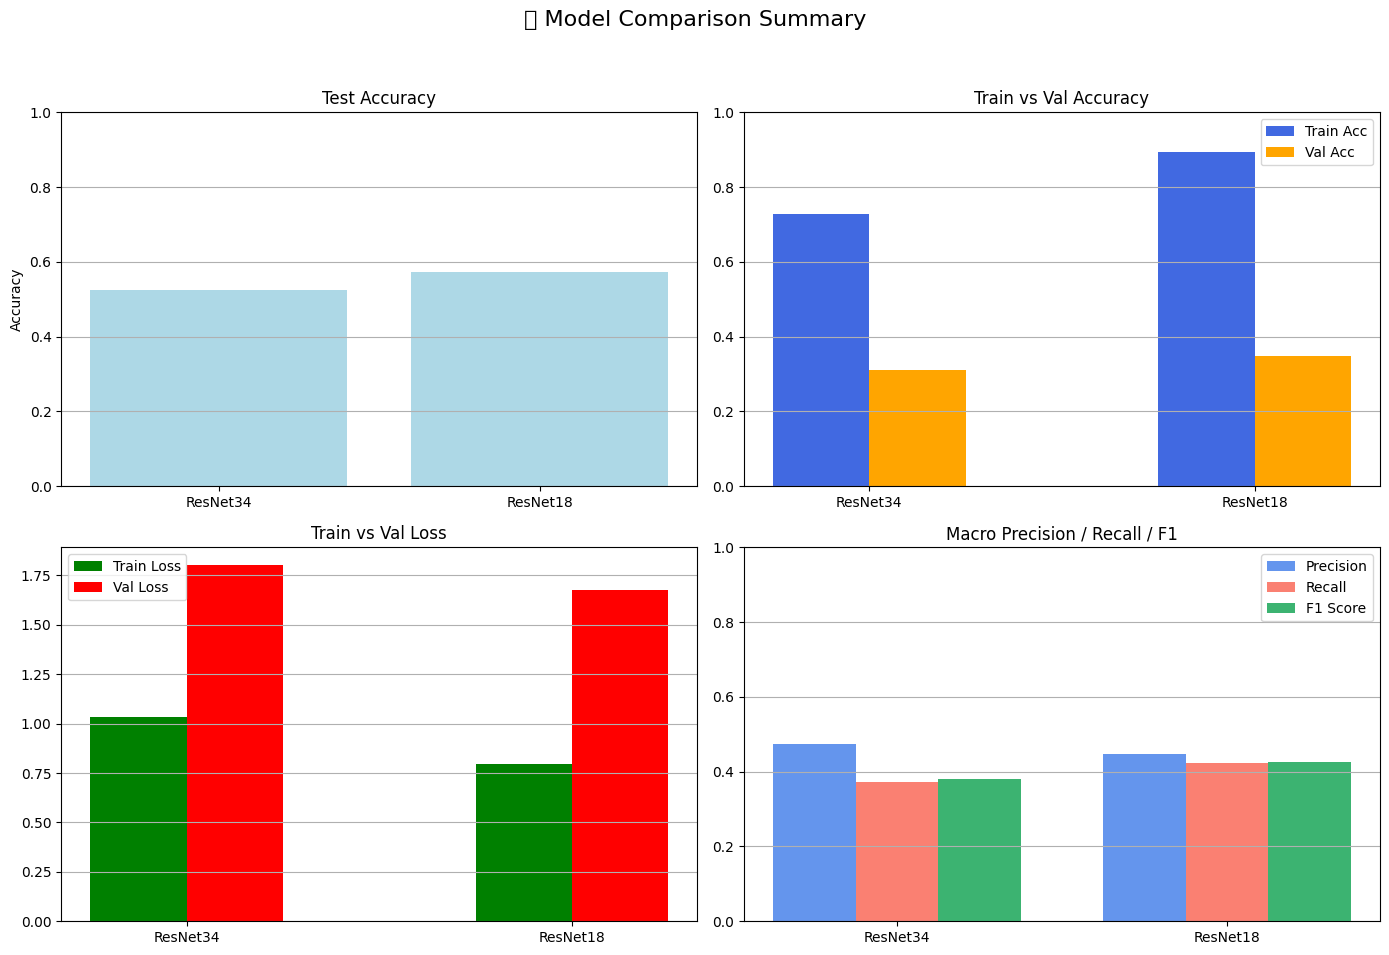

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(df):
    models = df['Model']
    x = np.arange(len(models))
    bar_width = 0.25

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("📊 Model Comparison Summary", fontsize=16)

    # 1️⃣ Test Accuracy
    axs[0, 0].bar(models, df['Test Acc'], color='lightblue')
    axs[0, 0].set_title("Test Accuracy")
    axs[0, 0].set_ylim(0, 1)
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].grid(axis='y')

    # 2️⃣ Train vs Val Accuracy
    axs[0, 1].bar(x - bar_width/2, df['Train Acc (last)'], width=bar_width, label='Train Acc', color='royalblue')
    axs[0, 1].bar(x + bar_width/2, df['Val Acc (last)'], width=bar_width, label='Val Acc', color='orange')
    axs[0, 1].set_title("Train vs Val Accuracy")
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(models)
    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].legend()
    axs[0, 1].grid(axis='y')

    # 3️⃣ Train vs Val Loss
    axs[1, 0].bar(x - bar_width/2, df['Train Loss (last)'], width=bar_width, label='Train Loss', color='green')
    axs[1, 0].bar(x + bar_width/2, df['Val Loss (last)'], width=bar_width, label='Val Loss', color='red')
    axs[1, 0].set_title("Train vs Val Loss")
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(models)
    axs[1, 0].legend()
    axs[1, 0].grid(axis='y')

    # 4️⃣ Macro Precision, Recall, F1
    axs[1, 1].bar(x - bar_width, df['Macro Precision'], width=bar_width, label='Precision', color='cornflowerblue')
    axs[1, 1].bar(x, df['Macro Recall'], width=bar_width, label='Recall', color='salmon')
    axs[1, 1].bar(x + bar_width, df['Macro F1'], width=bar_width, label='F1 Score', color='mediumseagreen')
    axs[1, 1].set_title("Macro Precision / Recall / F1")
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(models)
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].legend()
    axs[1, 1].grid(axis='y')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ✅ Call with your DataFrame
plot_model_comparison(pd.read_csv("model_results_log.csv"))